## Prepare Data ##

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
import matplotlib.pyplot as plt
import math

# Model Parameters
training_batch_size = 8
num_epochs_encoder = 50
num_epochs_decoder = 120
encoder_learning_rate = 0.004
decoder_learning_rate = 0.009

# Training / Validation Dataset
class SimulatorDataset(Dataset):
    """Simulator Data Dataset with normalization."""
    def __init__(self, csv_file, root_dir, transform=None):
        self.params_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
        # Normalize the feature data
        self.feature_scaler = MinMaxScaler()
        features = self.params_frame.loc[:, "ROB Size":"CPU Fetch Width"].values
        self.normalized_features = self.feature_scaler.fit_transform(features)
        
        # Normalize the label data
        self.label_scaler = MinMaxScaler()
        target = self.params_frame.loc[:, "Number of Cycles":"Power"].values
        self.normalized_target = self.label_scaler.fit_transform(target)
    
    def __len__(self):
        return len(self.params_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        data = self.normalized_features[idx]
        target = self.normalized_target[idx]
        sample = {'data': data, 'target': target}
        
        if self.transform is not None:
            sample = self.transform(sample)
        
        return sample

# Get dataset
sim_dataset = SimulatorDataset(csv_file='./modified_example.csv', root_dir='.',transform=None)

# Split into training and validation data (3 : 1 split)
val_dataset_size = len(sim_dataset) // 4
train_dataset_size = len(sim_dataset) - val_dataset_size
train_set, val_set = torch.utils.data.random_split(sim_dataset, [train_dataset_size, val_dataset_size])

# Prepare data loader
train_loader = DataLoader(train_set, batch_size=training_batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=training_batch_size, shuffle=True)

## Define Model ##

In [8]:
# Encoder Architecture
class EncoderMLP(nn.Module):
    def __init__(self):
        super(EncoderMLP, self).__init__()
        # Hidden Encoder Dim Layer 1
        self.layer1 = nn.Linear(6, 10)
        # Activation Function
        self.tanh1 = nn.Tanh()
        # Hidden Encoder Dim Layer 2
        self.layer2 = nn.Linear(10, 20)
        # Activation Function
        self.tanh2 = nn.Tanh()
        # Hidden Encoder Dim Layer 3
        self.layer3 = nn.Linear(20, 2)
        # Activation Function
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.tanh1(x)
        x = self.layer2(x)
        x = self.tanh2(x)
        x = self.layer3(x)
        x = self.sigmoid(x)
        return x

# Decoder Architecture
class DecoderMLP(nn.Module):
    def __init__(self):
        super(DecoderMLP, self).__init__()
        # Hidden Encoder Dim Layer 1
        self.layer1 = nn.Linear(2, 20)
        # Activation Function
        self.tanh1 = nn.Tanh()
        # Hidden Encoder Dim Layer 2
        self.layer2 = nn.Linear(20, 10)
        # Activation Function
        self.tanh2 = nn.Tanh()
        # Hidden Encoder Dim Layer 3
        self.layer3 = nn.Linear(10, 6)
        # Activation Function
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.tanh1(x)
        x = self.layer2(x)
        x = self.tanh2(x)
        x = self.layer3(x)
        x = self.sigmoid(x)
        return x

## Forward Training ##

### Encoder Training ###

In [9]:
# Initialize the encoder
encoder = EncoderMLP()

# Train encoder model first

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(encoder.parameters(), lr=encoder_learning_rate)

# Track training and validation loss per epoch
train_losses = []
val_losses = []

# Get initial losses

# Training loss
train_loss = count = 0
for i, batch in enumerate(train_loader):
    # get data and target
    data = batch['data'].float()
    target = batch['target'].float()
    # Forward pass
    outputs = encoder(data)
    loss = criterion(outputs, target)
    # Update training accuracy
    train_loss += loss
    count += 1
# Get final epoch train loss
train_loss = train_loss / count
train_losses.append(train_loss.detach().numpy())

# Val loss
val_loss = count = 0
for i, batch in enumerate(val_loader):
    # get data and target
    data = batch['data'].float()
    target = batch['target'].float()
    # Forward pass
    outputs = encoder(data)
    loss = criterion(outputs, target)
    # Update validation accuracy
    val_loss += loss
    count += 1
# Get final epoch validation loss
val_loss = val_loss / count
val_losses.append(val_loss.detach().numpy())

# Train the model
for epoch in range(num_epochs_encoder):

    # Report training accuracy
    train_loss = count = 0

    for i, batch in enumerate(train_loader):
        # free the gradient from the previous batch
        optimizer.zero_grad()

        # get data and target
        data = batch['data'].float()
        target = batch['target'].float()

        # Forward pass
        outputs = encoder(data)
        loss = criterion(outputs, target)

        # model backward
        loss.backward()
        # update the model paramters
        optimizer.step()

        # Update training accuracy
        train_loss += loss
        count += 1

    # Get final epoch train loss
    train_loss = train_loss / count
    train_losses.append(train_loss.detach().numpy())

    # Report validation accuracy
    val_loss = count = 0

    # Get validation loss (we only actually care about first 2 data points)
    for i, batch in enumerate(val_loader):

        # get data and target
        data = batch['data'].float()
        target = batch['target'].float()
        
        # Forward pass
        outputs = encoder(data)

        # Calculate loss
        loss = criterion(outputs, target)

        # Update validation accuracy
        val_loss += loss
        count += 1
    
    # Get final epoch validation loss
    val_loss = val_loss / count
    val_losses.append(val_loss.detach().numpy())

    # Print status check
    print(f"Epoch: [{epoch+1}/{num_epochs_encoder}], train_loss: {train_loss}, val_loss: {val_loss}")

Epoch: [1/50], train_loss: 0.024929320439696312, val_loss: 0.019969962537288666
Epoch: [2/50], train_loss: 0.02048758789896965, val_loss: 0.019067028537392616
Epoch: [3/50], train_loss: 0.019605519250035286, val_loss: 0.018299564719200134
Epoch: [4/50], train_loss: 0.01907011680305004, val_loss: 0.018990032374858856
Epoch: [5/50], train_loss: 0.01871737278997898, val_loss: 0.018313072621822357
Epoch: [6/50], train_loss: 0.018500108271837234, val_loss: 0.017479410395026207
Epoch: [7/50], train_loss: 0.01797376200556755, val_loss: 0.017029205337166786
Epoch: [8/50], train_loss: 0.017511550337076187, val_loss: 0.016234731301665306
Epoch: [9/50], train_loss: 0.016737796366214752, val_loss: 0.015442371368408203
Epoch: [10/50], train_loss: 0.015660950914025307, val_loss: 0.014804348349571228
Epoch: [11/50], train_loss: 0.014105383306741714, val_loss: 0.015243185684084892
Epoch: [12/50], train_loss: 0.012638633139431477, val_loss: 0.01158471591770649
Epoch: [13/50], train_loss: 0.011254648678

### Encoder Results ###

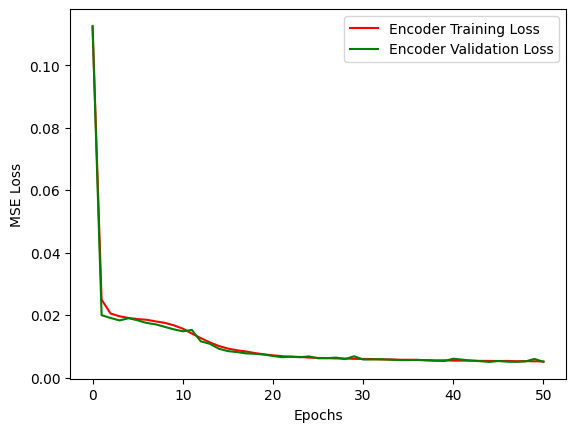

Final validation loss: 0.00500751007348299


In [10]:
# Get x axis
x_data = [x for x in range(num_epochs_encoder + 1)]

# Plot data
plt.plot(x_data, train_losses, c='r', label="Encoder Training Loss")
plt.plot(x_data, val_losses, c='g', label="Encoder Validation Loss")
plt.legend(loc="upper right")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.show()

# Report final data
print(f"Final validation loss: {val_losses[-1]}")

### Decoder (Inverse) Training ###

In [11]:
# Initialize the decoder
decoder = DecoderMLP()

# Now, we train decoder based on encoder output

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(decoder.parameters(), lr=decoder_learning_rate)

# Track training and validation loss per epoch
train_losses = []
val_losses = []

# Get initial losses

# Training loss
train_loss = count = 0
for i, batch in enumerate(train_loader):
    # get data and target
    data = batch['data'].float()
    target = batch['target'].float()
    # Forward pass (through encoder and decoder)
    outputs = encoder(data)
    outputs = decoder(outputs)
    # Calculate loss (compare output against incoming data)
    loss = criterion(outputs, data)
    # Update training accuracy
    train_loss += loss
    count += 1
# Get final epoch train loss
train_loss = train_loss / count
train_losses.append(train_loss.detach().numpy())

# Val loss
val_loss = count = 0
for i, batch in enumerate(val_loader):
    # get data and target
    data = batch['data'].float()
    target = batch['target'].float()
    # Forward pass (through encoder and decoder)
    outputs = encoder(data)
    outputs = decoder(outputs)
    # Calculate loss (compare output against incoming data)
    loss = criterion(outputs, data)
    # Update validation accuracy
    val_loss += loss
    count += 1
# Get final epoch validation loss
val_loss = val_loss / count
val_losses.append(val_loss.detach().numpy())

# Train the model
for epoch in range(num_epochs_decoder):

    # Report training accuracy
    train_loss = count = 0

    for i, batch in enumerate(train_loader):

        # get data and target
        data = batch['data'].float()
        target = batch['target'].float()

        # Forward pass to get encoder output
        encoder_output = encoder(data)

        # free the gradient from the previous batch
        optimizer.zero_grad()

        # Forward pass for decoder (compare against data)
        outputs = decoder(encoder_output)
        loss = criterion(outputs, data)

        # model backward
        loss.backward()
        # update the model paramters
        optimizer.step()

        # Update training accuracy
        train_loss += loss
        count += 1

    # Get final epoch train loss
    train_loss = train_loss / count
    train_losses.append(train_loss.detach().numpy())

    # Report validation accuracy
    val_loss = count = 0

    # Get validation loss (we only actually care about first 2 data points)
    for i, batch in enumerate(val_loader):

        # get data and target
        data = batch['data'].float()
        target = batch['target'].float()
        
        # Forward pass (through encoder and decoder)
        outputs = encoder(data)
        outputs = decoder(outputs)

        # Calculate loss (compare output against incoming data)
        loss = criterion(outputs, data)

        # Update validation accuracy
        val_loss += loss
        count += 1
    
    # Get final epoch validation loss
    val_loss = val_loss / count
    val_losses.append(val_loss.detach().numpy())

    # Print status check
    print(f"Epoch: [{epoch+1}/{num_epochs_decoder}], train_loss: {train_loss}, val_loss: {val_loss}")

Epoch: [1/100], train_loss: 0.09710538387298584, val_loss: 0.09506919234991074
Epoch: [2/100], train_loss: 0.09483582526445389, val_loss: 0.09697537124156952
Epoch: [3/100], train_loss: 0.0943199023604393, val_loss: 0.09387867152690887
Epoch: [4/100], train_loss: 0.09404180198907852, val_loss: 0.09421857446432114
Epoch: [5/100], train_loss: 0.09424597769975662, val_loss: 0.09698488563299179
Epoch: [6/100], train_loss: 0.09389828890562057, val_loss: 0.09304692596197128
Epoch: [7/100], train_loss: 0.09374923259019852, val_loss: 0.09687910228967667
Epoch: [8/100], train_loss: 0.09361352771520615, val_loss: 0.0938093364238739
Epoch: [9/100], train_loss: 0.09359504282474518, val_loss: 0.09498714655637741
Epoch: [10/100], train_loss: 0.0940035954117775, val_loss: 0.09471196681261063
Epoch: [11/100], train_loss: 0.09395597875118256, val_loss: 0.09557335078716278
Epoch: [12/100], train_loss: 0.0937274768948555, val_loss: 0.09334389865398407
Epoch: [13/100], train_loss: 0.09351319819688797, val

### Decoder (Inverse) Results ###

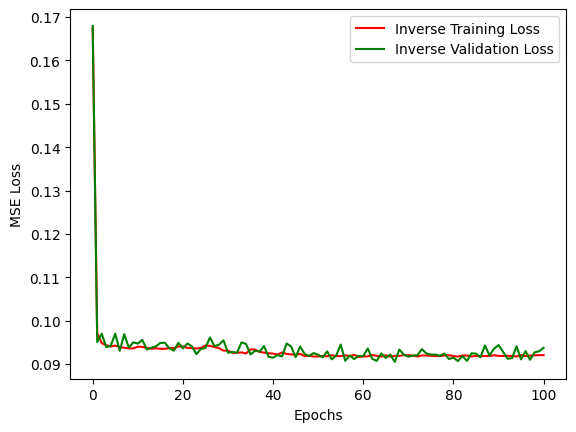

Final inverse validation loss: 0.09374502301216125


In [12]:
# Get x axis
x_data = [x for x in range(num_epochs_decoder + 1)]

# Plot data
plt.plot(x_data, train_losses, c='r', label="Inverse Training Loss")
plt.plot(x_data, val_losses, c='g', label="Inverse Validation Loss")
plt.legend(loc="upper right")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.show()

# Report final data
print(f"Final inverse validation loss: {val_losses[-1]}")